In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

Mounted at /content/drive


In [ ]:
import os

In [ ]:
path = '/content/drive/MyDrive/Colab Notebooks/Dataset'
if os.path.exists(path):
    print("Directory exists")
else:
    print("Directory does not exist")

Directory exists


In [ ]:
os.listdir('/content/drive/MyDrive/Colab Notebooks/Dataset') 

['white_spot',
 'gray_blight',
 'red_spot',
 'anthracnose',
 'brown_blight',
 'helopeltis',
 'healthy',
 'bird_eye_spot',
 'algal_spot']

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import PIL

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from sklearn.metrics import classification_report
import pathlib

In [ ]:

dataset_dir = pathlib.Path(path)

In [ ]:
class_names = []
for x in os.walk(path):
    sub_dir = x[0]
    sub_dir_list = str(sub_dir).split('/')
    if len(sub_dir_list) > 6:
        x_class = (sub_dir_list[-1])
        class_names.append(x_class)

print(class_names)

['white_spot', 'gray_blight', 'red_spot', 'anthracnose', 'brown_blight', 'helopeltis', 'healthy', 'bird_eye_spot', 'algal_spot']


In [ ]:
for class_i in class_names:
    image_count = len(list(dataset_dir.glob(f'{class_i}/*.png')))
    print(f"Images in class {class_i}:",image_count)

Images in class white_spot: 142
Images in class gray_blight: 1100
Images in class red_spot: 1143
Images in class anthracnose: 100
Images in class brown_blight: 980
Images in class helopeltis: 1010
Images in class healthy: 1074
Images in class bird_eye_spot: 100
Images in class algal_spot: 1113


In [ ]:
train_batch = 16
val_batch = 16
img_height = 224
img_width = 224
IMG_SIZE = (img_height, img_width)
val_split = 0.2


In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,
                                                       validation_split=val_split,
                                                       subset="training",
                                                       seed=123,
                                                       image_size=(img_height, img_width),
                                                       batch_size=train_batch
                                                      )

Found 6762 files belonging to 9 classes.
Using 5410 files for training.


In [ ]:
val_ds = tf.keras.utils.image_dataset_from_directory(dataset_dir,                                                            
                                                     validation_split=val_split,                                                            
                                                     subset="validation",                                                     
                                                     seed=123,                                                     
                                                     image_size=(img_height, img_width),                                                     
                                                     batch_size=val_batch                                                           
                                                    )

Found 6762 files belonging to 9 classes.
Using 1352 files for validation.


In [ ]:
train_ds.class_names

['algal_spot',
 'anthracnose',
 'bird_eye_spot',
 'brown_blight',
 'gray_blight',
 'healthy',
 'helopeltis',
 'red_spot',
 'white_spot']

In [ ]:
class_names = train_ds.class_names
print(class_names)

num_classes=len(class_names)

['algal_spot', 'anthracnose', 'bird_eye_spot', 'brown_blight', 'gray_blight', 'healthy', 'helopeltis', 'red_spot', 'white_spot']


In [ ]:

# plt.figure(figsize=(10, 10))
# for images, labels in train_ds.take(1):
#     for i in range(9):
#         ax = plt.subplot(3, 3, i + 1)
#         plt.imshow(images[i].numpy().astype("uint8"))
#         plt.title(class_names[labels[i]])
#         plt.axis("off")

In [ ]:
train_ds.take(1)

<_TakeDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal",input_shape=(img_height,img_width,3)),
    layers.RandomFlip("vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
])


In [ ]:
# Its a custom CNN model


model = Sequential([
    data_augmentation,
    layers.Rescaling(1./255),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(32, activation='relu'),
    layers.Dropout(0.3),
    layers.BatchNormalization(),
    layers.Dense(num_classes)
])


In [ ]:
from keras.models import Model
from keras.layers import Dense,Flatten
from keras.applications import vgg16
from keras import backend as K

modelVGG = vgg16.VGG16(weights='imagenet', include_top=True)
modelVGG.trainable=False

modelVGG.input

modelVGG.summary(line_length=150)

modelVGG.layers.pop()
modelVGG.layers.pop()

modelVGG.summary(line_length=150)

new_layer = Dense(9, activation='softmax', name='my_dense')

inp = modelVGG.input
out = new_layer(modelVGG.layers[-1].output)

model = Model(inp, out)

553467096/553467096 [==============================] - 18s 0us/step
Model: "vgg16"
______________________________________________________________________________________________________________________________________________________
 Layer (type)                                                      Output Shape                                                Param #                
 input_1 (InputLayer)                                              [(None, 224, 224, 3)]                                       0                      
                                                                                                                                                      
 block1_conv1 (Conv2D)                                             (None, 224, 224, 64)                                        1792                   
                                                                                                                                                      
 block1_con

In [ ]:
base_learning_rate = 0.001
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])


In [ ]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

In [ ]:
epochs=50
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs,
    batch_size=16,
    verbose=1
)

Epoch 1/50
339/339 [==============================] - 1439s 903ms/step - loss: 2.1909 - accuracy: 0.1512 - val_loss: 2.1844 - val_accuracy: 0.1561
Epoch 2/50
339/339 [==============================] - 27s 80ms/step - loss: 2.1773 - accuracy: 0.1634 - val_loss: 2.1719 - val_accuracy: 0.1612
Epoch 3/50
339/339 [==============================] - 32s 95ms/step - loss: 2.1646 - accuracy: 0.1684 - val_loss: 2.1604 - val_accuracy: 0.1686
Epoch 4/50
339/339 [==============================] - 27s 80ms/step - loss: 2.1528 - accuracy: 0.1782 - val_loss: 2.1496 - val_accuracy: 0.1731
Epoch 5/50
339/339 [==============================] - 27s 80ms/step - loss: 2.1418 - accuracy: 0.1871 - val_loss: 2.1396 - val_accuracy: 0.1783
Epoch 6/50
339/339 [==============================] - 27s 80ms/step - loss: 2.1315 - accuracy: 0.1998 - val_loss: 2.1303 - val_accuracy: 0.1842
Epoch 7/50
339/339 [==============================] - 27s 80ms/step - loss: 2.1219 - accuracy: 0.2076 - val_loss: 2.1217 - val_accura

[0.15120147168636322, 0.16340111196041107, 0.1683918684720993, 0.1781885325908661, 0.18706099689006805, 0.19981515407562256, 0.20757855474948883, 0.2133086919784546, 0.2216266244649887, 0.22476895153522491, 0.2269870638847351, 0.22846581041812897, 0.22902032732963562, 0.231238454580307, 0.23179297149181366, 0.23197782039642334, 0.23419593274593353, 0.23475046455860138, 0.2345656156539917, 0.23696857690811157, 0.23733825981616974, 0.2377079427242279, 0.23937153816223145, 0.2388170063495636, 0.2408502846956253, 0.23955637216567993, 0.2410351186990738, 0.24048058688640594, 0.24158965051174164, 0.24251386523246765, 0.24251386523246765, 0.24380776286125183, 0.24177448451519012, 0.24251386523246765, 0.24214418232440948, 0.24325323104858398, 0.24343807995319366, 0.24343807995319366, 0.24269869923591614, 0.24436229467391968, 0.24417744576931, 0.24491682648658752, 0.245101660490036, 0.24473197758197784, 0.2462107241153717, 0.24750462174415588, 0.2495379000902176, 0.2506469488143921, 0.250646948

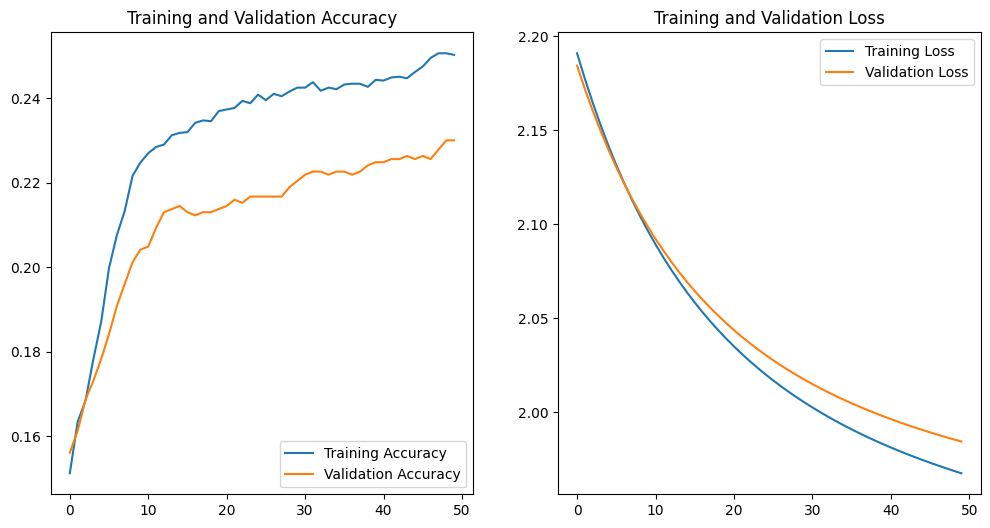

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
print(acc)
print(val_acc)

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

Predictions:
 [7 0 0 0 0 7 7 0 0 0 7 0 0 7 7 7]
Labels:
 [0 4 5 6 5 4 6 3 7 6 0 0 0 6 7 5]

              precision    recall  f1-score   support

           0       0.22      0.50      0.31         4
           3       0.00      0.00      0.00         1
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         3
           6       0.00      0.00      0.00         4
           7       0.14      0.50      0.22         2

    accuracy                           0.19        16
   macro avg       0.06      0.17      0.09        16
weighted avg       0.07      0.19      0.10        16



/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


,loss,accuracy,val_loss,val_accuracy
45,1.973192,0.247505,1.989341,0.226331
46,1.971720,0.249538,1.988063,0.225592
47,1.970299,0.250647,1.986827,0.227811
48,1.968913,0.250647,1.985628,0.230030
49,1.967575,0.250277,1.984464,0.230030


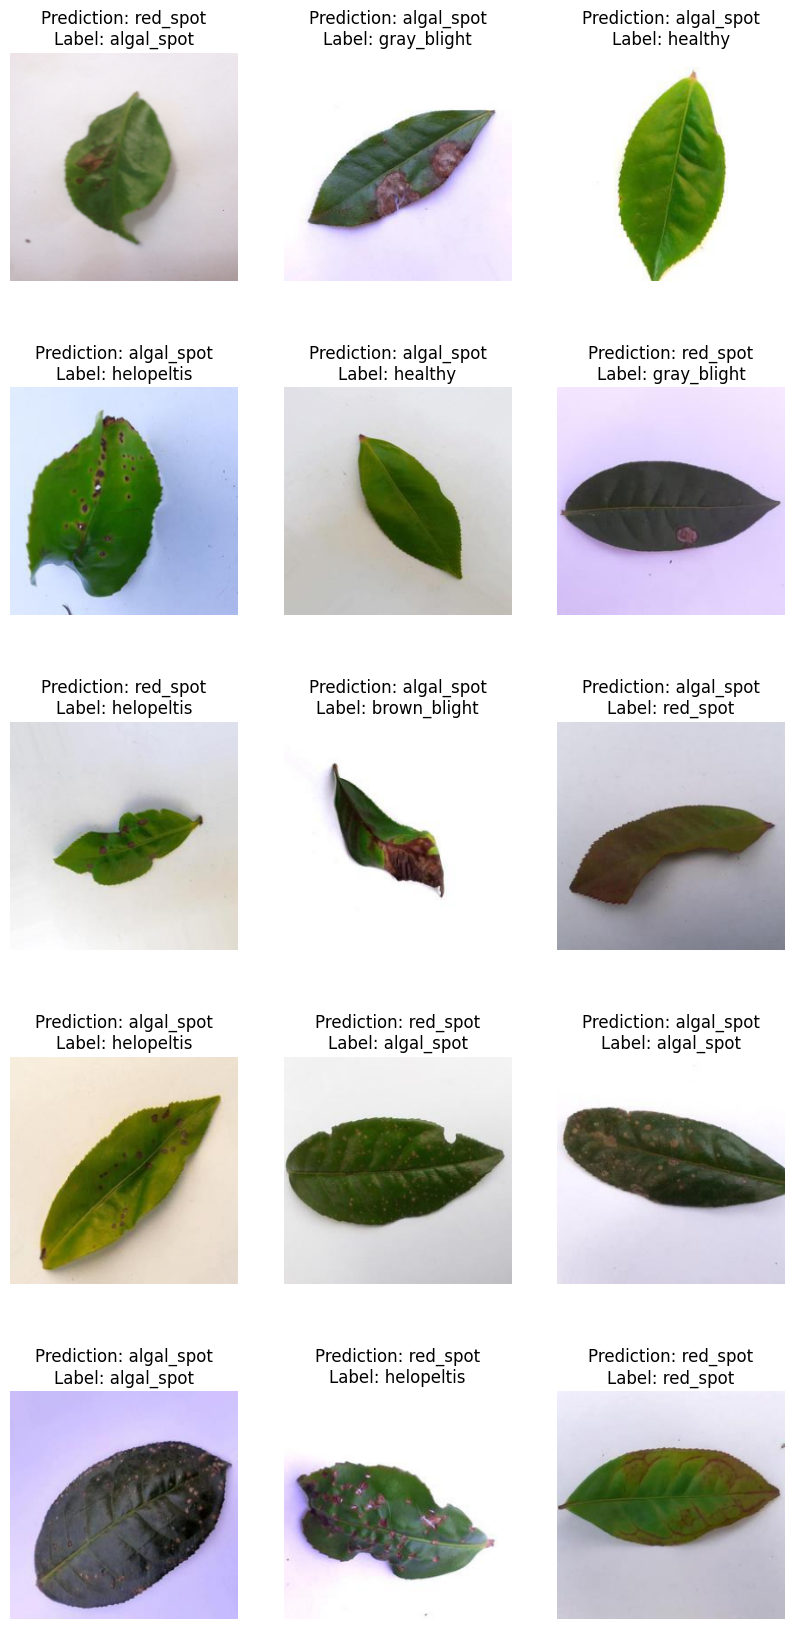

In [ ]:
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

class_predictions = []
for i in predictions:
    class_prediction = np.argmax(i)
    class_predictions.append(class_prediction)

class_predictions = np.array(class_predictions)
print('Predictions:\n', class_predictions)
print('Labels:\n', label_batch)
print()
print(classification_report(label_batch, class_predictions))

plt.figure(figsize=(10, 21))
for i in range(15):
    ax = plt.subplot(5, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title("Prediction: "+class_names[class_predictions[i]]+"\nLabel: "+class_names[label_batch[i]])
    plt.axis("off")

history_df = pd.DataFrame(history.history)
history_df.to_csv("history.csv")
history_df.tail()